### Practical Section

In this section, we will be looking into one of the practical reinforcement learning problems populary known as the Cartpole Problem using OpenAI Gym for our learning environment.\
The carpole problem consists of an inverted pendulum mounted on a cart. At any given state, the environment returns four observations to the agent. These observations are the position of the cart, velocity of the cart, angle of the pole and lastly the angular velocity of the pole. The agent using these observations has to decide on one of two possible actions, either move the cart to the left  or right. 
The goal of the agent is to balance the pole and keep it balanced for longer period of time. The agent recieves a  reward of +1 at each time step its able to keep the pole upright and -1 if it fails. The environment returns 'done' if the agent fails to balance the pole or if the maximum time-step for an episode is reached. In the cartpole environment,the agent fails to balance:

1. if the angle of the pole is greater than $\pm 12^{\circ}$ 
2. Cart position is exceeds $\pm 2.4$


$\bullet$ We will build our agent on Q-learning algorithm, therefore the update rule for our Q values is:
\begin{equation}
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \big[R_{t+1} + \gamma \max_a Q(s_{t+1},a) - Q(s,a) \big] 
\end{equation}
$\bullet$ The agent will be trained using $\epsilon$-greedy exploration. \
$\bullet$ We will be using Cartpole version 1(CartPole-v1)\
$\bullet$ We will set our maximum step per epiode to 450 since CartPole-v1 comes with a default maximum step of 500



### Importing modules
We start by importing the needed packages.
Gym is for our Cartpole environment

In [1]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import random

In [2]:
my_seed_b = 50   #100 # we set random seed for consistent results

In [3]:
random.seed(my_seed_b)

### Cartpole Agent
We create our cartpole agent here.
We initialize our parameters, try to reduce the dimension of the observation space domain. We then discretize the observation space by creating bins.\
We create our Q-value look up table to help us in the action selection. 


In [4]:
class Q_Cartpole_Agent():
    def __init__(self, num_buckets=(1, 1, 6, 12), num_episodes=1000, episode_max_step=450, learning_rate=0.001, min_explore_rate=0.01, discount=1.0, decay_rate=25):
        self.buckets = num_buckets
        self.num_episodes = num_episodes
        self.learning_rate = learning_rate
        self.min_explore_rate = min_explore_rate
        self.discount = discount
        self.decay_rate = decay_rate
        self.episode_max_step = episode_max_step
        self.env6 = gym.make('CartPole-v1')
        self.env6.seed(my_seed_b)
        self.env6.action_space.seed(my_seed_b)
        
         # [position, velocity, angle, angular velocity]
        self.upper_bounds = [self.env6.observation_space.high[0], 0.5, self.env6.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env6.observation_space.low[0], -0.5, self.env6.observation_space.low[2], -math.radians(50) / 1.]

        self.Q_table = np.zeros(self.buckets + (self.env6.action_space.n,))#we initialize the values to zero
        
        #discretizing the observation space
    def discretize(self, observation):
        discretized = list()
        for i in range(len(observation)):
            scale = (observation[i] + abs(self.lower_bounds[i])) / (self.upper_bounds[i] - self.lower_bounds[i])
            new_observation = int(round((self.buckets[i] - 1) * scale))
            new_observation = min(self.buckets[i] - 1, max(0, new_observation))
            discretized.append(new_observation)
        return tuple(discretized)
    
    #define our epsilon greedy policy
    def choose_action(self, state):
        np.random.seed(my_seed_b)
        if np.random.rand() <= self.explore_rate:
            return self.env6.action_space.sample() 
        else:
            return np.argmax(self.Q_table[state])
     
    def update_q_table(self, state, action, reward, new_state):
        self.Q_table[state][action] += self.learning_rate * (reward + self.discount * np.max(self.Q_table[new_state]) - self.Q_table[state][action])
   

    def loss(self, state, action, reward, new_state): #defining the error using Mean squared error
        m_s_error = (reward + self.discount * np.max(self.Q_table[new_state]) - self.Q_table[state][action])**2
        return m_s_error
    
    

    def set_explore_rate(self, t):
        return max(self.min_explore_rate, min(1., 1. - math.log10((t + 1) / self.decay_rate)))
    
    
    def train(self):
        total_rewards = []
        err_train = []
        for episode in range(self.num_episodes):
            current_state = self.discretize(self.env6.reset())

            
            episode_rewards = 0
            self.explore_rate = self.set_explore_rate(episode)
            #done = False
            err_episode = []
            
            for time_step in range(self.episode_max_step ):
                
                
                action = self.choose_action(current_state)
                
                new_state, reward, done, _ = self.env6.step(action)
                
                new_state = self.discretize(new_state)
                
                self.update_q_table(current_state, action, reward, new_state)
                err = self.loss(current_state, action, reward, new_state)

                            
                #incrementing reward
                episode_rewards += reward
                
                current_state = new_state
                
                err_episode.append(err)
                
                if done == True:
                
                    break
                
           #appending episode reward to the total reward
            total_rewards.append(episode_rewards)
            
            err_train.append(np.mean(err_episode))
        #Maximum =   max(total_rewards)  
        print('Training completed')
        print('Maximum reward of training obtained is {} in episode {}'.format(max(total_rewards), total_rewards.index(max(total_rewards)))) 
         
        return total_rewards ,err_train
           
        
        
    def Test(self):
        rewards_test = []
        err_test = []
        for episode in range(101):
            current_state = self.env6.reset()
            current_state = self.discretize(current_state)
            self.explore_rate = self.set_explore_rate(episode)
            episode_rewards_test = 0
            err2 = []
            for time_step in range(self.episode_max_step):
                self.env6.render() 
                action = self.choose_action(current_state)
                new_state, reward, done, _ = self.env6.step(action)
                new_state = self.discretize(new_state)
                self.update_q_table(current_state, action, reward, new_state)
                t_err = self.loss(current_state, action, reward, new_state)
                
                episode_rewards_test += reward
                current_state = new_state
                err2.append(t_err)
                
                if done == True:
                    print('Episode:{}/{} completed with a total reward of {}'.format(episode, 100, episode_rewards_test))
                    break
                
                    #appending episode reward to the total reward
            rewards_test.append(episode_rewards_test)
            
            err_test.append(np.mean(err2))
    
                   #Getting the average
        sum_rewards = (sum(i for i in rewards_test)) /len(rewards_test)

        continuous_rewards = (sum(rewards_test))/(len(rewards_test)*self.episode_max_step)
        print('Maximum reward obtained is {} in episode {}'.format((max(rewards_test)),rewards_test.index(max(rewards_test))))
        print('Average reward is {}'.format(sum_rewards))
        print('Countinous form  reward is {}'.format(continuous_rewards)) 
      
        self.env6.close()

        return rewards_test, err_test
    
if __name__ == "__main__":
    agent = Q_Cartpole_Agent()
    train_agent = agent.train()
    test_agent = agent.Test()

                  

Training completed
Maximum reward of training obtained is 191.0 in episode 672
Episode:0/100 completed with a total reward of 18.0
Episode:1/100 completed with a total reward of 24.0
Episode:2/100 completed with a total reward of 28.0
Episode:3/100 completed with a total reward of 41.0
Episode:4/100 completed with a total reward of 14.0
Episode:5/100 completed with a total reward of 11.0
Episode:6/100 completed with a total reward of 57.0
Episode:7/100 completed with a total reward of 47.0
Episode:8/100 completed with a total reward of 31.0
Episode:9/100 completed with a total reward of 42.0
Episode:10/100 completed with a total reward of 13.0
Episode:11/100 completed with a total reward of 17.0
Episode:12/100 completed with a total reward of 23.0
Episode:13/100 completed with a total reward of 34.0
Episode:14/100 completed with a total reward of 31.0
Episode:15/100 completed with a total reward of 18.0
Episode:16/100 completed with a total reward of 26.0
Episode:17/100 completed with 

## Plotting Results

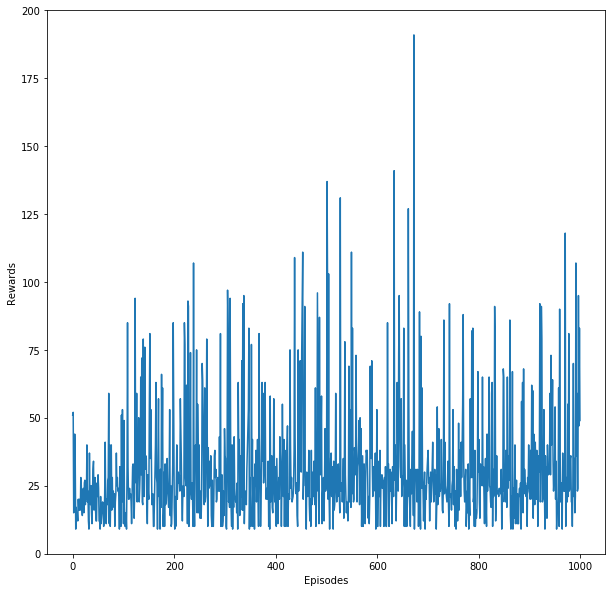

In [11]:
#plotting rewards from 
plt.figure(figsize=(10, 10))
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.plot(np.array(train_agent[0]))
plt.savefig('cartpole_Qlearning_train_Main2')

In [6]:
#smoothing the rewards with mean
s2 = []
a_r2 = np.zeros(50)

for i in range(0,1000,20):
    a_r2 = np.mean(np.array(train_agent[0])[i:i+20])
    s2.append(a_r2)
    
    
    

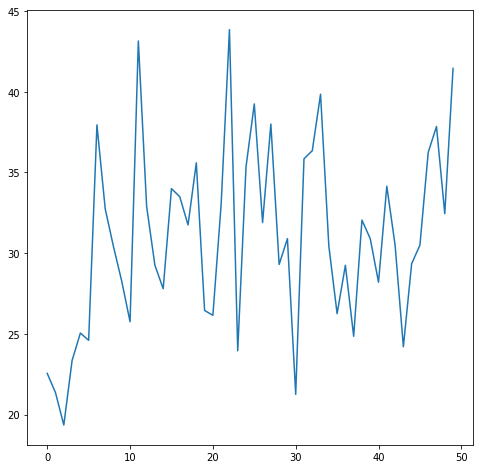

In [7]:
plt.figure(figsize=(8, 8))
plt.plot(np.array(s2))
#plt.savefig('cartpole_Qlearning_smoothed_Main1')

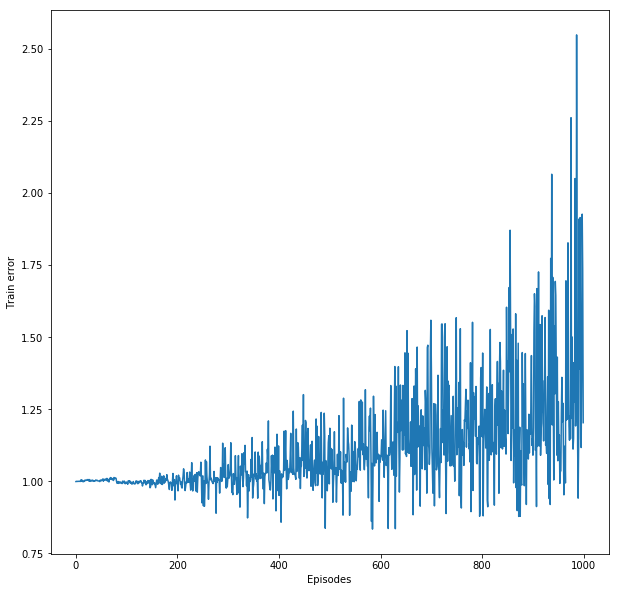

In [12]:
#plotting error
plt.figure(figsize=(10, 10))
plt.xlabel("Episodes")
plt.ylabel('Train error')
plt.plot(np.array(train_agent[1]))
plt.savefig('cartpole_Qlearning_error_Main2')

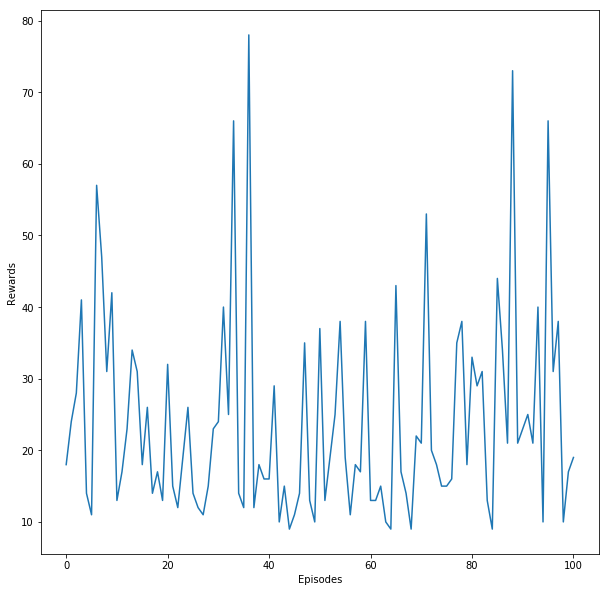

In [13]:
#plotting rewards from testing
plt.figure(figsize=(10, 10))
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.plot(np.array(test_agent[0]))
plt.savefig('cartpole_Qlearning_test_Main2')

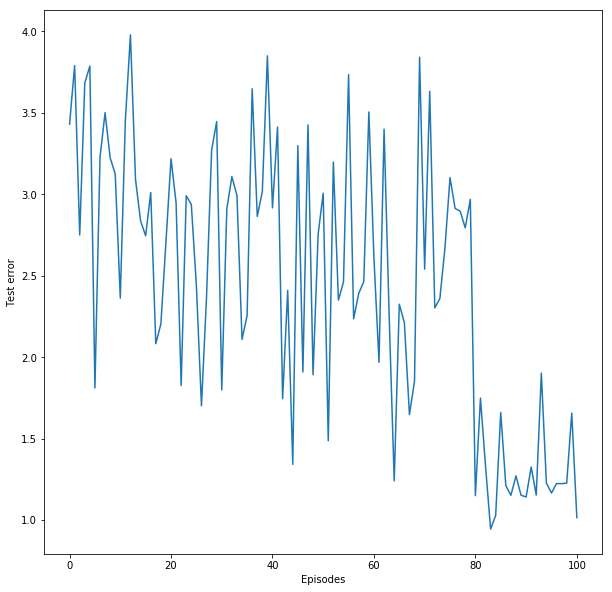

In [14]:
#plotting errors of testing
plt.figure(figsize=(10, 10))
plt.xlabel("Episodes")
plt.ylabel('Test error')
plt.plot(np.array(test_agent[1]))
plt.savefig('cartpole_Qlearning_errTest_Main2')

### Results